# Hough Transform Testing

In [3375]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import ndimage as nd
import random

In [3376]:
# Find all normal lines from point pairs
def points2lines(points):
    lines = np.zeros([1,3])
    r,c = points.shape
    while(r>1):
        for i in np.arange(1,r):
            line = np.cross(points[0,:], points[i,:])
            lines = np.vstack([lines, line])
        points = points[1:,:]
        r,c = points.shape
    lines = lines[1:,:]
 
    return lines

# Convert linear eqn to rho-theta
def plane2hough(lines):

    slope = -lines[0]/lines[1]
    theta = math.atan(-1/slope)
    if theta !=(0):
        b = -lines[2]/lines[1]
        x = -b/(slope+1/slope)
        y = slope*x + b
        rho = x*np.cos(theta) + y*np.sin(theta)
    else:
        rho = -lines[2]/lines[0]
    rhotheta = [rho, theta]

    return rhotheta

def gradientMag(image):
    sobelx = np.array([[1,0,-1],
                    [2,0,-2],
                    [1,0,-1]])

    sobely = np.array([[ 1, 2, 1],
                    [ 0, 0, 0],
                    [-1,-2,-1]])

    Ix = nd.convolve(image,sobelx)
    Iy = nd.convolve(image,sobely)
    mag = np.sqrt(Ix**2+Iy**2)
    return mag

Create a test image of a square

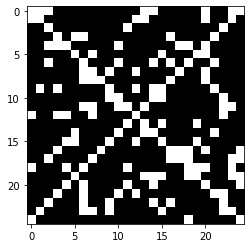

In [3377]:
# Create image with lines
r = 25
c = r
image = 100*np.ones([r,c])
line = 155*np.eye(r)
image = np.fliplr(image+line)
image = image+line

# Add noise to the image
sigma = 20
mean = 0
noise = sigma*np.random.randn(r,c) + mean
image = image+noise
plt.imshow(image, cmap='gray', vmin=0, vmax=255)

# Submax supression
threshold = 0.3
mask = 1*( image >= threshold*np.amax(image))
edgels = np.where(mask==1)
edgels = np.array(edgels).T
plt.imshow(mask, cmap='gray')

# RANSAC
Random Sample Consensus

In [3378]:
def RANSAC(data,model,threshold):
    # probability that one sample is clean
    p = 0.99
    # probablility that point is an outlier
    e = 0.8
    # number of samples needed
    N = np.log(1-p) / np.log(1-(1-e)**model)
    N = np.int(np.round(N))

    # [num of inliers, rho, theta, (x1,y1), (x2,y2)]
    votes = np.zeros(9)
    bestFit = 0

    # Add a column of 1's to the end
    r,c = data.shape
    data = np.hstack([data, np.ones([r,1])])

    i = 0
    while i < N:
        # Find two random edgels
        pair = np.random.randint(data.shape[0],size=2)

        # Insure pairs are unique
        while pair[0] == pair[1]:
            pair[1] = np.random.randint(data.shape[0])
        pair = data[pair]

        # Convert edgels to (a,b,c)
        plane = points2lines(pair)
        plane = np.concatenate(plane)

        # Edgel distance to plane
        plane_norm = np.sqrt(np.sum(plane[0:2]**2))
        dist = np.abs(np.dot(data,plane.T)) / plane_norm

        # Threshold distances
        inliers = data[dist <= threshold]
        num_inlier = np.sum(inliers[:,2])

        if num_inlier > votes[0]:

            rhotheta = plane2hough(plane)
            votes = np.hstack([num_inlier, rhotheta, np.reshape(pair,6)])

        i += 1
    

    print(np.around(votes,3))
    # Refit with inliers
    pair = np.reshape(votes[3:],(2,3))

    # Convert edgels to (a,b,c)
    plane = points2lines(pair)
    plane = np.concatenate(plane)
    
    # Edgel distance to plane
    plane_norm = np.sqrt(np.sum(plane[0:2]**2))
    dist = np.abs(np.dot(data,plane.T)) / plane_norm
    
    inliers = data[dist <= threshold]
    inliers = inliers.astype(int)

    return inliers[:,0:2]


[53.    -0.733 -0.822  0.     1.     1.    14.    14.     1.   ]


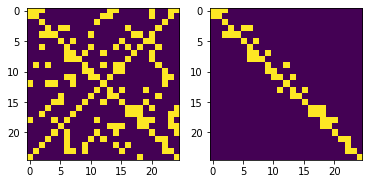

In [3379]:
model = 2
threshold = 2
inliers = RANSAC(edgels,model,threshold)

plt.subplot(1,2,1)
plt.imshow(mask)

plt.subplot(1,2,2)
good = np.zeros([mask.shape[0], mask.shape[0]])
good[inliers[:,0], inliers[:,1]] = 1
plt.imshow(good)